# Clasificador paisajes
Para este ejercicio vas a crear un clasificador automático de paisajes. Los datos los encontrarás en el Clasroom como `seg_train.zip` y `seg_test.zip`. Se pide:
1. Cargar las imágenes. Mira cómo están almacenados los datos. Tendrás que recorrer las carpetas, cargar las imágenes en memoria y etiquetarlas con los nombres de las carpetas. Realiza un reshape de cada imagen (comienza el ejercicio con 32x32, para ir más rápido en las ejecuciones).
2. Investiga las imágenes, comprueba con algunas muestras que has cargado bien los datos.
3. Normaliza
4. Diseña la arquitectura de la red. Recuerda que es un algiritmo de clasificación. Ojo con las dimensiones de la entrada
5. Reserva un 20% de los datos del entrenamiento para validar.
6. Representa el objeto history
7. Evalua el modelo con los datos de test
8. Representa algunos de los paisajes donde el modelo comete errores
9. Crea una matriz de confusión con los errores del modelo

**NOTA apartado 1**: para el apartado 1 tendras que recorre las carpetas/imagenes con `os.listdir()`, e ir cargando todas las imagenes como arrays de numpy

**NOTA apartado 4**: empieza con un par de capas Conv2D + MaxPooling2D con activación relu y después la fully connected layer. on softmax como ultima capa

In [73]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)

IMAGE_SIZE = (32, 32)

In [22]:
import numpy as np
import os
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tqdm import tqdm

In [23]:
def load_data():
    
    datasets = [ "../../../../DataSets/landscapes/seg_train/",
                "../../../../DataSets/landscapes/seg_test/"]
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]
            
            # Iterate through each image in our folder. tqdm is a widget in output...
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [24]:
(train_images, train_labels), (test_images, test_labels) = load_data()

100%|██████████| 501/501 [00:00<00:00, 1501.36it/s]


In [25]:
n_train = train_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of testing examples: {}".format(n_test))
print("Each image is of size: {}".format(IMAGE_SIZE))

Number of training examples: 14034
Number of testing examples: 3000
Each image is of size: (32, 32)


<AxesSubplot:>

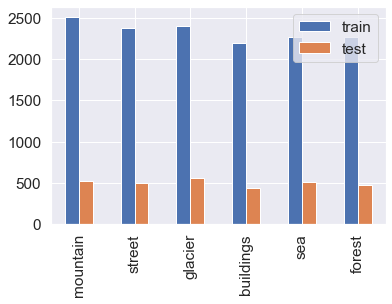

In [26]:
import pandas as pd

_, train_counts = np.unique(train_labels, return_counts=True)
_,test_counts = np.unique(test_labels, return_counts=True)
pd.DataFrame({'train': train_counts,
             'test': test_counts},
            index = class_names).plot.bar()

Text(0.5, 1.0, 'Proportion of each observed category')

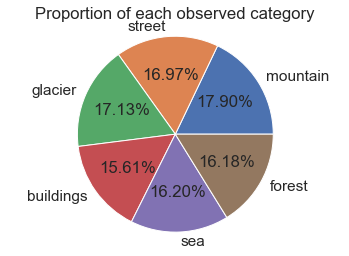

In [27]:
plt.pie(train_counts,
       explode = (0, 0, 0, 0, 0, 0),
       labels = class_names,
       autopct='%1.2f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
        

In [28]:
train_images = train_images / 255.0
test_images = test_images / 255.0

In [29]:
def display_random_image(class_names, images, labels):
    """
        Display a random image from the images array and its correspond label
        from the labels array
    """
    
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    

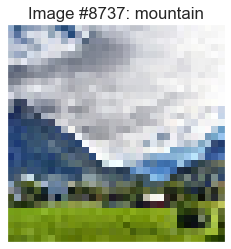

In [30]:
display_random_image(class_names, train_images, train_labels)

In [31]:
# las primeras 25 imágenes

def display_examples(class_names, images, labels):
    """
    Display 25 images from the images array with its corresponding labels
    """
    
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    

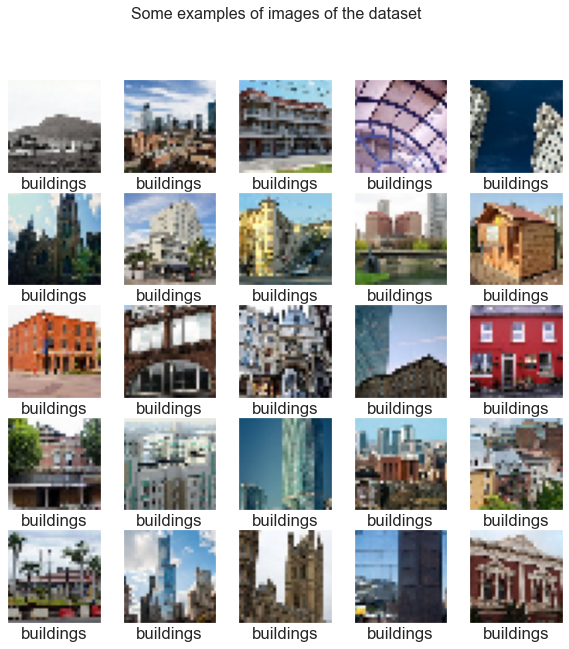

In [32]:
display_examples(class_names, train_images, train_labels)

In [48]:
# 1. Vamos a crear el modelo
# 2. Compilamos el modelo
# 3. Train/fit los datos en el modelo
# 4. Evaluamos el modelo con el test
# 5. Hacemos un análisis de los errores

In [49]:
# Construimos un modelo sencillo compuesto de:
# * Conv2D: (32 filtros de 3x3)
# * MaxPooling2D (las imágenes se quedan en la mitad del tamaño)
# * Flatten: transformamos el formato de 2D a 1D con 150 150 3 valores de los píxels
# * Relu: dado un valor x, devuelve max(x,0)
# * Softmax: 6 neuronas, es la probabilidad de que la imagen pertenezca a una de las clases


In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu',
                           input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(6, activation=tf.nn.softmax)
    
])

In [34]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [35]:
train_images.shape, train_labels.shape

((14034, 32, 32, 3), (14034,))

In [36]:
history = model.fit(train_images, train_labels, batch_size = 128, epochs = 10, validation_split = 0.2)

Epoch 1/10
88/88 [==============================] - 10s 111ms/step - loss: 1.2991 - accuracy: 0.4586 - val_loss: 8.3371 - val_accuracy: 0.0485
Epoch 2/10
88/88 [==============================] - 9s 105ms/step - loss: 0.8768 - accuracy: 0.6582 - val_loss: 10.1569 - val_accuracy: 0.0499
Epoch 3/10
88/88 [==============================] - 9s 106ms/step - loss: 0.7935 - accuracy: 0.6980 - val_loss: 10.1414 - val_accuracy: 0.0951
Epoch 4/10
88/88 [==============================] - 9s 106ms/step - loss: 0.7216 - accuracy: 0.7368 - val_loss: 11.4785 - val_accuracy: 0.0631
Epoch 5/10
88/88 [==============================] - 9s 106ms/step - loss: 0.6580 - accuracy: 0.7528 - val_loss: 11.7133 - val_accuracy: 0.0766
Epoch 6/10
88/88 [==============================] - 10s 110ms/step - loss: 0.6169 - accuracy: 0.7773 - val_loss: 12.4012 - val_accuracy: 0.0933
Epoch 7/10
88/88 [==============================] - 9s 104ms/step - loss: 0.5926 - accuracy: 0.7869 - val_loss: 13.0983 - val_accuracy: 0.086

In [37]:
def plot_accuracy_loss(history):
    """
    Plot the accuracy and the loss during the training of the nn
    """
    
    fig = plt.figure(figsize=(15,10))
    
    # plot accuracy
    plt.subplot(221)
    plt.plot(history.history['accuracy'], 'bo--', label = 'acc')
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()
    
    plt.subplot(222)
    plt.plot(history.history['loss'], 'bo--', label = 'loss')
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()

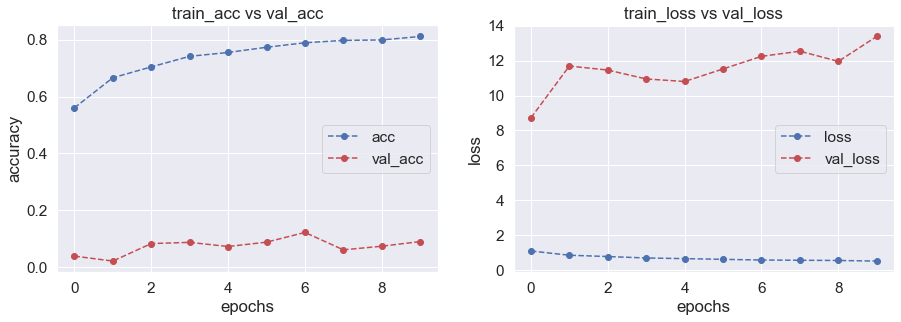

In [57]:
plot_accuracy_loss(history)

In [38]:
# evaluamos la performance del modelo en el test

test_loss = model.evaluate(test_images, test_labels)

94/94 [==============================] - 1s 8ms/step - loss: 3.1980 - accuracy: 0.6657


In [39]:
test_loss

[3.1980085372924805, 0.6656666398048401]

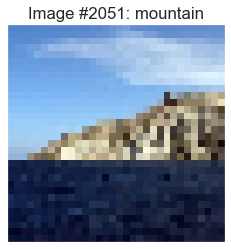

In [40]:
predictions = model.predict(test_images) # vector de probabilidades
pred_labels = np.argmax(predictions, axis=1) # nos quedamoscon la probabilidad más alta

display_random_image(class_names, test_images, pred_labels)

In [41]:
# análisis del error
def print_mislabeled_images (class_names, test_images, test_labels, pred_labels):
    """
    Print 25 examples of mislabeled images by the classifier,
    when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]
    
    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names, mislabeled_images, mislabeled_labels)
    

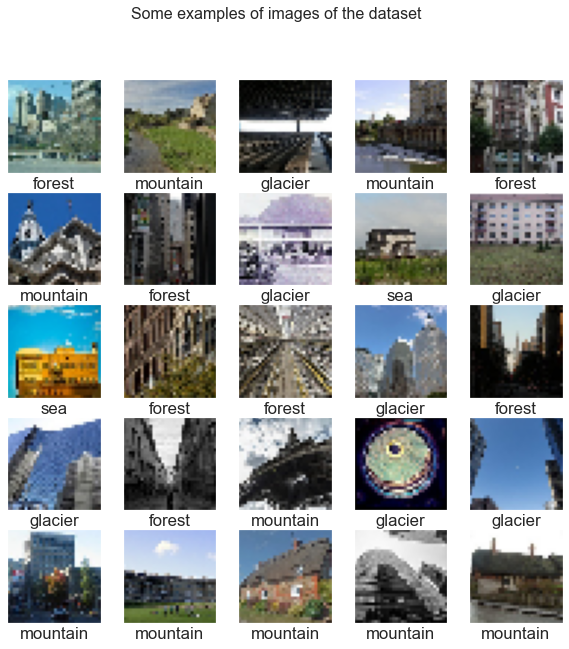

In [42]:
print_mislabeled_images(class_names, test_images, test_labels, pred_labels)

Text(0.5, 1.0, 'Confusión matrix')

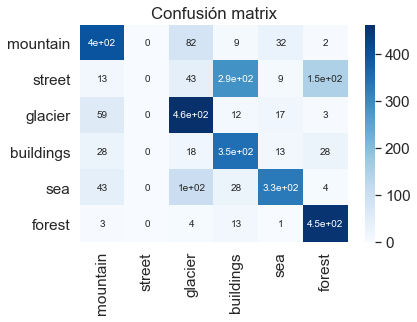

In [43]:
CM = confusion_matrix(test_labels, pred_labels)

ax = plt.axes()
sn.heatmap(CM,
            annot=True,
            annot_kws= {"size": 10},
            xticklabels= class_names,
            yticklabels= class_names, 
            ax= ax,
            cmap='Blues')
ax.set_title("Confusión matrix")

In [ ]:
#VAMOS A HACER USO DE UN MODELO == PLANTILLAS DE REDES NEURONALES

In [44]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

In [45]:
model = VGG16(weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 89s 2us/step


In [46]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [47]:
n_train, x, y, z = train_features.shape
n_test, x, y, z = test_features.shape
numFeatures = x * y * z

In [53]:
print('x', x)
print('y', y)
print('z', z) # z ==> son las 512 categorías que están definidas en el modelo VGG16

x 1
y 1
z 512


In [59]:
train_features.shape #Tensor ==> matriz de matrices

(14034, 1, 1, 512)

In [54]:
train_features[0,0,0,:] #Nos indica el procentaje de predicción sobre cada categoría (512) que tiene el modelo_VGG16 de la foto_indice_0

array([0.        , 0.        , 0.16601479, 0.29005212, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.26061758, 0.        , 0.12489486, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.04722506, 0.        ,
       0.        , 0.        , 0.        , 0.2890188 , 0.        ,
       0.        , 0.        , 0.32069463, 0.        , 0.63987935,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.05091128, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.45268777,
       0.7265394 , 0.        , 0.        , 0.73963964, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [55]:
train_features[0,0,0,:].max()

8.909288

In [56]:
train_features[0,0,0,:].argmax()

155

In [61]:
train_features[0,0,0,155]

8.909288

In [51]:
test_features.shape

(3000, 1, 1, 512)

In [48]:
numFeatures

512

In [74]:
# visualizamos
from sklearn import decomposition
pca = decomposition.PCA(n_components = 2)
X = train_features.reshape((n_train, x*y*z))
pca.fit(X)
C = pca.transform(X)
C1 = C[:,0]
C2 = C[:,1] 
#Estamos transformado a sólo en 2Features (Componente principales) de (32*32 pixeles), porque queremos representarlo en un gráfico 2Dimensiones

Text(0.5, 1.0, 'PCA Projection')

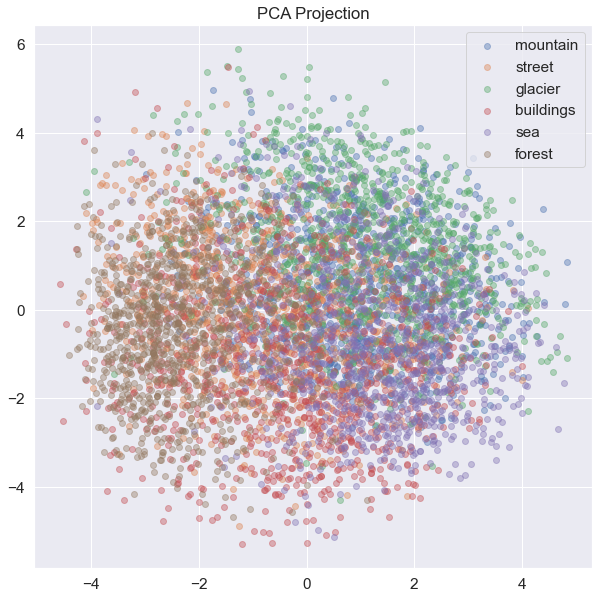

In [75]:
# figuras
plt.subplots(figsize=(10,10))
for i, class_name in enumerate(class_names):
    plt.scatter(C1[train_labels == i][:1000],
                C2[train_labels == i][:1000], label = class_name, alpha=0.4)
plt.legend()
plt.title("PCA Projection")

In [ ]:
#Que vamos a hacer ahora??
#Entrenar ese modelo con nuestras fotos y además con una red_neuronal definida por nosotros, con sólo 6 nodos de output(clasificación)

In [79]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape= (x, y, z)),
    tf.keras.layers.Dense(50, activation= tf.nn.relu),
    tf.keras.layers.Dense(6, activation= tf.nn.softmax)
])

In [82]:
model2.compile(optimizer= 'adam',
               loss = 'sparse_categorical_crossentropy',
               metrics = ['accuracy'])


In [83]:
history2 = model2.fit(train_features, train_labels,
                      batch_size= 128,
                      epochs= 15,
                      validation_split= 0.2)

Epoch 1/15
88/88 [==============================] - 1s 6ms/step - loss: 1.2643 - accuracy: 0.5077 - val_loss: 6.6782 - val_accuracy: 0.0823
Epoch 2/15
88/88 [==============================] - 0s 3ms/step - loss: 0.6898 - accuracy: 0.7423 - val_loss: 7.6526 - val_accuracy: 0.0930
Epoch 3/15
88/88 [==============================] - 0s 4ms/step - loss: 0.6332 - accuracy: 0.7590 - val_loss: 8.1845 - val_accuracy: 0.0873
Epoch 4/15
88/88 [==============================] - 0s 4ms/step - loss: 0.5942 - accuracy: 0.7819 - val_loss: 8.5587 - val_accuracy: 0.0965
Epoch 5/15
88/88 [==============================] - 0s 3ms/step - loss: 0.5711 - accuracy: 0.7847 - val_loss: 8.6332 - val_accuracy: 0.0955
Epoch 6/15
88/88 [==============================] - 0s 3ms/step - loss: 0.5654 - accuracy: 0.7940 - val_loss: 8.8646 - val_accuracy: 0.0933
Epoch 7/15
88/88 [==============================] - 0s 3ms/step - loss: 0.5493 - accuracy: 0.7944 - val_loss: 9.1671 - val_accuracy: 0.0923
Epoch 8/15
88/88 [==

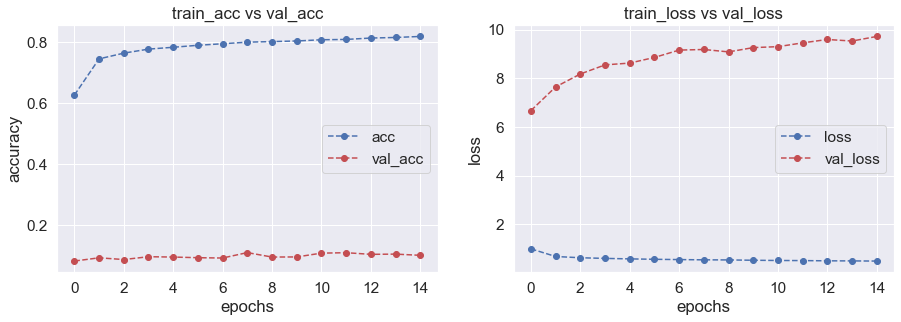

In [85]:
plot_accuracy_loss(history2)

In [86]:
test_loss = model2.evaluate(test_features, test_labels)

94/94 [==============================] - 0s 1ms/step - loss: 2.3643 - accuracy: 0.6483


In [87]:
##### OTRO APARTADO
# Ensamblado redes neuronales (Bagging https://www.pluralsight.com/guides/ensemble-methods:-bagging-versus-boosting )
#Vamos a hacer 10 redes neuronales_sencillas que combinándolas intentar sacar las mejores predicciones

In [89]:
np.random.seed(seed = 1997)
#nuemro de estimadores
n_estimators = 10 #Diez redes neuronales distintas entre sí

#proporción de muestras para usar en train y test
max_samples = 0.8

max_samples *= n_train # ==> max_samples = max_samples * n_train
max_samples = int(max_samples)

In [120]:
models = list()
random = np.random.randint(50,100, size= n_estimators)


In [121]:
random

array([76, 76, 88, 89, 61, 87, 76, 66, 87, 50])

In [122]:
for i in range(n_estimators):
    #model
    model = tf.keras.Sequential([
                                 tf.keras.layers.Flatten(input_shape= (x, y, z)),
                                 #una capa de un tamaño de neuronas aleatorio
                                 tf.keras.layers.Dense(units= random[i], activation = tf.nn.relu),
                                 tf.keras.layers.Dense(units = 6, activation=tf.nn.softmax)
                                    ])
                                    
    model.compile(optimizer= 'adam',
                  loss= 'sparse_categorical_crossentropy',
                  metrics= ['accuracy'])

    # guardamos el modelo
    models.append(model)

In [123]:
models

In [124]:
histories = [] # se crea una lista, lo mismo que histories = list()

for i in range(n_estimators):
    #entrenamos cada modelo con la bolsa de los datos train
    train_idx = np.random.choice(len(train_features), size = max_samples)
    histories.append(models[i].fit(train_features[train_idx], train_labels[train_idx],
                                  batch_size= 128,
                                  epochs=10,
                                  validation_split= 0.1))


Epoch 1/10
79/79 [==============================] - 1s 4ms/step - loss: 1.4116 - accuracy: 0.4668 - val_loss: 0.8618 - val_accuracy: 0.6705
Epoch 2/10
79/79 [==============================] - 0s 4ms/step - loss: 0.7992 - accuracy: 0.7102 - val_loss: 0.7616 - val_accuracy: 0.6990
Epoch 3/10
79/79 [==============================] - 0s 3ms/step - loss: 0.7180 - accuracy: 0.7279 - val_loss: 0.7331 - val_accuracy: 0.7053
Epoch 4/10
79/79 [==============================] - 0s 3ms/step - loss: 0.6512 - accuracy: 0.7540 - val_loss: 0.7181 - val_accuracy: 0.7168
Epoch 5/10
79/79 [==============================] - 0s 3ms/step - loss: 0.6403 - accuracy: 0.7646 - val_loss: 0.7036 - val_accuracy: 0.7346
Epoch 6/10
79/79 [==============================] - 0s 3ms/step - loss: 0.6039 - accuracy: 0.7738 - val_loss: 0.6873 - val_accuracy: 0.7346
Epoch 7/10
79/79 [==============================] - 0s 3ms/step - loss: 0.5832 - accuracy: 0.7859 - val_loss: 0.6847 - val_accuracy: 0.7320
Epoch 8/10
79/79 [==

In [142]:
histories[0].history['val_accuracy'][-3:]

[0.7444345355033875, 0.7488868832588196, 0.7551202178001404]

In [135]:
histories[5].history['val_loss']

[0.830970823764801,
 0.7385686635971069,
 0.700165331363678,
 0.6731621623039246,
 0.6513866186141968,
 0.6458700895309448,
 0.6253745555877686,
 0.6204931735992432,
 0.6215580701828003,
 0.6017361283302307]

In [141]:
histories[9].history['val_accuracy'][-3:]

[0.7702582478523254, 0.7791629433631897, 0.7702582478523254]

In [161]:
predictions =[]
for i in range(n_estimators):
    predictions.append(models[i].predict(test_features))

predictions = np.array(predictions)
predictions_sum = predictions.sum(axis= 0) #sumo los 3000_Registros por columnas, por cada una de las 6_categorias
pred_labels = predictions_sum.argmax(axis= 1)  #Extraigo el indices del mayor_valor de la suma de columnas(mayor probabilidad que sea una clase)... sacaremos su índice

In [171]:
 print(predictions[0].shape) #predicciones de la 1a foto 
 predictions[9][0] , predictions[9][0] 


(3000, 6)


(array([3.0540268e-05, 3.4074602e-03, 1.7925488e-03, 9.9437100e-01,
        3.9829875e-04, 2.6260656e-07], dtype=float32),
 array([3.0540268e-05, 3.4074602e-03, 1.7925488e-03, 9.9437100e-01,
        3.9829875e-04, 2.6260656e-07], dtype=float32))

In [ ]:
"""
foto 0 (montaña):

nn0 (6 categorias) ==> prediccion 0.0 - 0.0 - 0.1 - 0.0 - 0.4 - 0.5
nn1 (6 categorias) ==> prediccion 0.0 - 0.1 - 0.1 - 0.0 - 0.9 - 0.0
nn2 (6 categorias) ==> prediccion 0.0 - 0.3 - 0.1 - 0.2 - 0.4 - 0.0
.
.
.
nn9 (6 categorias) ==> prediccion 0.0 - 0.1 - 0.1 - 0.0 - 0.3 - 0.5


suma(axis=1_columnas) ==>         0.0 - 0.5 - 0.4 - 0.2 - 2.0 - 1.0

argmax(de la suma por fila) ==> 4


"""

In [175]:
from sklearn.metrics import accuracy_score
print("Accuracy: {}". format(round(accuracy_score(test_labels, pred_labels),3)))

Accuracy: 0.75
